In [28]:
import numpy as np
import math
import scipy
import matplotlib.pyplot as plt

In [9]:
def PSD(row,df):
    PSD_row = np.fft.fft(row)
    PSD_row = PSD_row / len(PSD_row)
    PSD_row = PSD_row[:round(len(PSD_row)/2)]
    PSD_row += 0.00001
    PSD_row = pow(np.abs(PSD_row),2)

    f = np.linspace(0,df//2,len(PSD_row))
    
    return f,10*np.log10(PSD_row)

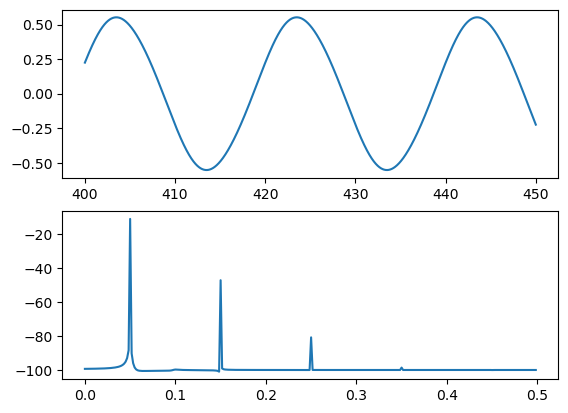

In [74]:
df = 250
dt = 1/df
L_s = 1000
L = L_s*df
x = np.ones(L)
t = np.linspace(0,L_s,L)
Eps = 2
Tau = round(3.6*df)
Alpha = -1.65
Betta = 1

Resp = np.sin(2*math.pi*0.05*t)

for i in range(Tau,L):
    x[i] = dt*(-x[i-1] + Alpha*np.tanh(Betta*x[i-Tau])+Resp[i])/Eps + x[i-1]


x = x[400*df:]
t = t[400*df:]
Resp = Resp[400*df:] 
f,PSD_x = PSD(x,df)
plt.subplot(2,1,1)
plt.plot(t[:50*df],x[:50*df])
plt.subplot(2,1,2)
plt.plot(f[:300],PSD_x[:300])
plt.show()

In [44]:
'''
Resp = np.sin(2*math.pi*1*t)
Phase = 2*math.pi*1*t
Phase_num = np.unwrap(np.angle(scipy.signal.hilbert(Resp))) #Гильберт 1 ряда
plt.subplot(2,1,1)
plt.plot(t[:5*df]-400,Resp[:5*df])
plt.subplot(2,1,2)
plt.plot(t[:5*df]-400,Phase[:5*df]-min(Phase))
plt.plot(t[:5*df]-400,Phase_num[:5*df]-min(Phase_num))
plt.show()
'''

'\nResp = np.sin(2*math.pi*1*t)\nPhase = 2*math.pi*1*t\nPhase_num = np.unwrap(np.angle(scipy.signal.hilbert(Resp))) #Гильберт 1 ряда\nplt.subplot(2,1,1)\nplt.plot(t[:5*df]-400,Resp[:5*df])\nplt.subplot(2,1,2)\nplt.plot(t[:5*df]-400,Phase[:5*df]-min(Phase))\nplt.plot(t[:5*df]-400,Phase_num[:5*df]-min(Phase_num))\nplt.show()\n'

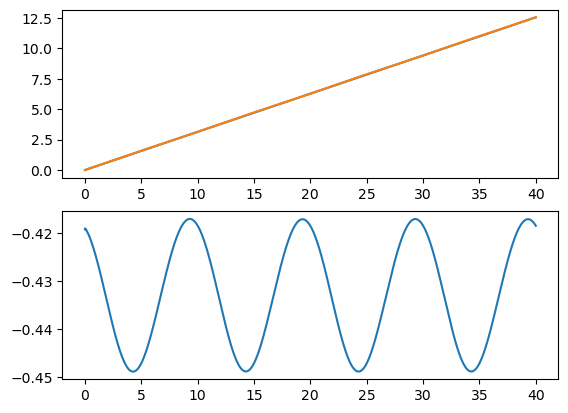

In [75]:
Phase_resp = np.unwrap(np.angle(scipy.signal.hilbert(Resp))) #Гильберт 1 ряда
Phase_x = np.unwrap(np.angle(scipy.signal.hilbert(x))) #Гильберт 1 ряда
plt.subplot(2,1,1)
plt.plot(t[:40*df]-400,Phase_resp[:40*df]-min(Phase_resp))
plt.plot(t[:40*df]-400,Phase_x[:40*df]-min(Phase_x))

plt.subplot(2,1,2)
plt.plot(t[:40*df]-400,Phase_resp[:40*df]-Phase_x[:40*df])
plt.show()

In [76]:
from scipy.optimize import curve_fit

def line(x,a,b):
    return a*x + b

popt, pcov = curve_fit(line, t,Phase_resp-Phase_x)
A = popt[0]
print(A)

3.5305715507521395e-07


In [86]:
from scipy.optimize import curve_fit

def line(x,a,b):
    return a*x + b
    
def Synch_det(df,f_resp,gain):
    dt = 1/df
    L_s = 1000
    L = L_s*df
    
    x = np.ones(L)
    t = np.linspace(0,L_s,L)
    Eps = 2
    Tau = round(3.6*df)
    Alpha = -1.65
    Betta = 1

    Resp = np.sin(2*math.pi*f_resp*t)

    for i in range(Tau,L):
        x[i] = dt*(-x[i-1] + Alpha*np.tanh(Betta*x[i-Tau])+gain*Resp[i])/Eps + x[i-1]


    x = x[400*df:]
    t = t[400*df:]
    Resp = Resp[400*df:] 

    Phase_resp = np.unwrap(np.angle(scipy.signal.hilbert(Resp))) #Гильберт 1 ряда
    Phase_x = np.unwrap(np.angle(scipy.signal.hilbert(x))) #Гильберт 1 ряда

    Phase_diff = Phase_resp - Phase_x

    popt, pcov = curve_fit(line, t,Phase_diff)
    A = popt[0]

    return A

In [87]:
Resp_freq = np.linspace(0.05,0.15,16)
Gain_array = np.linspace(0,0.5,16)

Map = np.zeros((16,16))
for i in range(len(Resp_freq)):
    print(i)
    for j in range(len(Gain_array)):
        Map[len(Resp_freq)-j-1,i] = Synch_det(df,Resp_freq[i],Gain_array[j])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


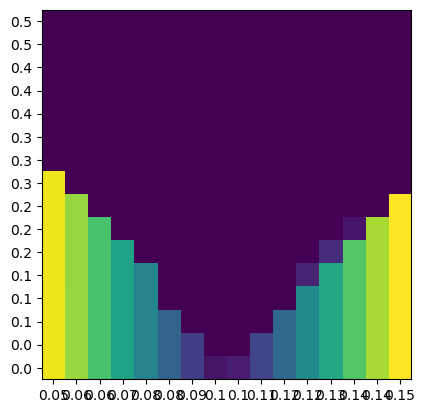

In [88]:
plt.imshow(abs(Map), cmap='viridis')
plt.xticks(np.arange(len(Resp_freq)),np.round(Resp_freq,2))
plt.yticks(np.arange(len(Gain_array)),np.round(Gain_array[::-1],1))

plt.show()